# Fit a model of item similarity to inference task data

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import dsmplot
from mindstorm import statplot
from tesser import tasks
from tesser import network
from tesser import model
from tesser import figures

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'model')
model_name = 'sr-comm-gqw_a10'
model_dir = os.path.join(fig_dir, model_name)

## Load structure learning and inference task data

In [2]:
struct = tasks.load_struct(data_dir)
induct = tasks.load_induct(data_dir)

## Define inference model parameter search

In [3]:
# simple model of similarity based on community membership
nodes = network.node_info()
comm = nodes['community'].to_numpy()
within_mat = (comm == comm[:, None]).astype(float)

# define free and fixed parameters
fixed = {'alpha': 0.1}
var_names = ['gamma', 'w1', 'w2', 'w3', 'tau']
var_bounds = {
    'alpha': [0, 1],
    'gamma': [0, 1],
    'tau': [0, 10],
    'w1': [0, 1],
    'w2': [0, 1],
    'w3': [0, 1],
}

# define similarity matrices
sim1_spec = {'alpha': 'alpha', 'gamma': 'gamma'}
sim2_spec = {'sim': within_mat}

# set similarity matrix weighting parameters
question_param = {
    'central': {'w': 'w1'}, 'boundary1': {'w': 'w2'}, 'boundary2': {'w': 'w3'}
}

## Estimate best-fitting parameters

In [4]:
full_results = model.fit_induct(
    struct,
    induct,
    fixed,
    var_names,
    var_bounds,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
    n_job=6,
    n_rep=10,
)
full_results

,logl,n,k,alpha,gamma,w1,w2,w3,tau
rep,,,,,,,,,
0,-1344.199800,1554,5,0.1,0.000000,0.582499,0.974015,0.0,1.282622
1,-1344.199800,1554,5,0.1,0.000000,0.582500,0.974012,0.0,1.282616
2,-1344.199800,1554,5,0.1,0.000000,0.582499,0.974016,0.0,1.282618
3,-1344.199800,1554,5,0.1,0.000000,0.582498,0.974015,0.0,1.282621
4,-1344.199800,1554,5,0.1,0.000000,0.582478,0.974063,0.0,1.282643
5,-1343.795727,1554,5,0.1,0.974242,0.804045,1.000000,0.0,1.392231
6,-1343.795727,1554,5,0.1,0.974241,0.804044,1.000000,0.0,1.392232
7,-1343.795727,1554,5,0.1,0.974240,0.804033,1.000000,0.0,1.392228
8,-1343.795727,1554,5,0.1,0.974242,0.804046,1.000000,0.0,1.392246


In [7]:
results = model.save_fit_results(
    model_dir,
    full_results,
    fixed,
    var_names,
    var_bounds,
    sim1_spec,
    sim2_spec,
    question_param,
)
results

,logl,n,k,alpha,gamma,w1,w2,w3,tau
rep,,,,,,,,,
6,-1343.795727,1554,5,0.1,0.974241,0.804044,1.0,0.0,1.392232


## Plot model similarity matrices

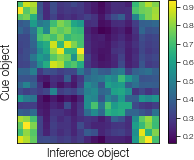

In [15]:
s1 = struct.query('subject == 100')
sr = model.learn_struct_sr(s1, 0.95, results['alpha'], 21)

fig, ax = plt.subplots(figsize=(3, 3))
h = dsmplot.plot_dsm(sr, prange=(0, 100), checks=False, ax=ax);
fig.colorbar(h, shrink=0.735);
ax = plt.gca()
ax.set_axis_on()
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Inference object', size='large')
ax.set_ylabel('Cue object', size='large')
plt.savefig(os.path.join(fig_dir, f'temporal_bias_model-{model_name}_sr.pdf'))

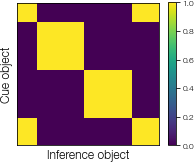

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))
h = dsmplot.plot_dsm(within_mat, prange=(0, 100), checks=False, ax=ax)
fig.colorbar(h, shrink=0.735);
ax = plt.gca()
ax.set_axis_on()
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Inference object', size='large')
ax.set_ylabel('Cue object', size='large')
plt.savefig(os.path.join(fig_dir, 'temporal_bias_model_within.pdf'))

## Plot similarity matrix weights

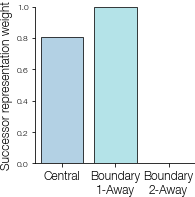

In [17]:
colors = figures.get_induct_colors()
rm = results.melt(value_vars=['w1', 'w2', 'w3'], var_name='parameter')
fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data=rm,
    x='parameter',
    y='value',
    dodge=True,
    palette=colors['light'],
    edgecolor='k',
    linewidth=0.75,
    ax=ax,
);
ax.set(
    ylabel='Successor representation weight',
    xlabel='',
    ylim=(0, 1.01),
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
)
ax.spines['left'].set_bounds(0, 1)
ax.tick_params(axis='x', labelsize='large');
fig.savefig(os.path.join(fig_dir, f'temporal_bias_param-{model_name}.pdf'))

## Get fitted response probabilities for inference

In [18]:
temp = results.copy()
stats = model.get_fitted_prob(
    temp,
    induct,
    struct,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
)
stats

,subject,trial,trial_type,environment,community,cue,opt1,opt2,within,response,response_time,correct,prob_response,prob_correct
0,100,1,central,ocean,1,2,16,20,2,NaN,NaN,NaN,NaN,NaN
1,100,2,boundary2,desert,2,4,10,19,1,2.0,2.974157,0.0,0.327774,0.672226
2,100,3,central,desert,2,5,6,2,1,1.0,3.190848,1.0,0.594925,0.594925
3,100,4,central,ocean,1,2,9,19,2,2.0,3.373906,1.0,0.613770,0.613770
4,100,5,central,ocean,1,1,19,13,1,2.0,3.094699,0.0,0.370375,0.629625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,138,38,central,desert,2,8,9,21,1,2.0,2.025821,0.0,0.442170,0.557830
1550,138,39,central,forest,3,14,19,15,2,2.0,1.997691,1.0,0.587673,0.587673
1551,138,40,central,ocean,1,21,14,2,2,2.0,1.114204,1.0,0.615101,0.615101
1552,138,41,boundary1,forest,3,11,10,16,2,1.0,0.623270,0.0,0.434210,0.565790


## Probability by subject and trial type

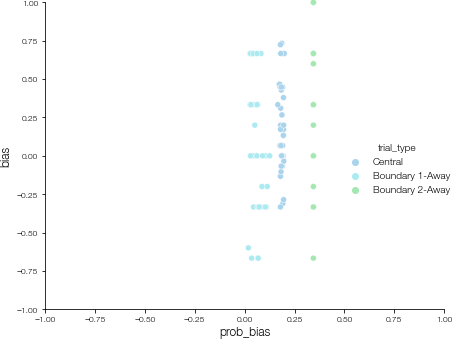

In [19]:
m = stats.groupby(['subject', 'trial_type'])[['correct', 'prob_correct']].mean().reset_index()
m['bias'] = (m['correct'] - .5) * 2
m['prob_bias'] = (m['prob_correct'] - .5) * 2
m['trial_type'] = m['trial_type'].map(
    {
        'central': 'Central',
        'boundary1': 'Boundary 1-Away',
        'boundary2': 'Boundary 2-Away',
    }
)

g = sns.relplot(
    data=m.reset_index(), x='prob_bias', y='bias', hue='trial_type', clip_on=False, palette=colors['light']
)
g.set(xlim=(-1, 1), ylim=(-1, 1));

## Mean probability by trial type

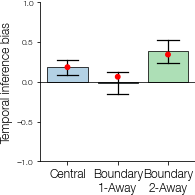

In [20]:
gm = m.groupby('trial_type').mean().reset_index()
fig, ax = plt.subplots(figsize=(3, 3))
# data
sns.barplot(
    data=m,
    x='trial_type',
    y='bias',
    hue='trial_type',
    palette=colors['light'],
    edgecolor='k',
    linewidth=0.75,
    dodge=False,
    capsize=0.425,
    zorder=0,
    ax=ax,
)
# model fit
sns.pointplot(
    data=m,
    x='trial_type',
    y='prob_bias',
    color='r',
    linewidth=0.75,
    dodge=False,
    join=False,
    ci=None,
    zorder=1000,
    ax=ax,
)
plt.setp(ax.lines, zorder=50, linewidth=1.25, color='k', label=None)
plt.setp(ax.collections, zorder=100, label=None)
ax.set(
    ylabel='Temporal inference bias',
    ylim=(-1, 1),
    yticks=np.arange(-1, 1.5, .5),
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
);
ax.axline((0, 0), slope=0, color='k', linewidth=.75);
ax.spines['left'].set_bounds(-1, 1)
ax.set_xlabel('')
ax.get_legend().remove()
ax.tick_params(axis='x', labelsize='large');
fig.savefig(os.path.join(model_dir, f'induct_mean_fit.pdf'))